In [4]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
import warnings
import pickle as pkl
import sys, time

warnings.filterwarnings("ignore")

In [5]:
# start with a smaller site so things don't take fooooorever
site_name = 'worldbuilding.stackexchange.com'

In [6]:
site = StackSite(site_name)

In [7]:
df_dict = site.generate_dfs()

# Generate K-Fold Test/Train Splits

I'll generate train/test splits for the questions and comments (the former is obvious, the latter is just to be fair about training the internal gensim dictionary on an appropriately smaller corpus). Then for each fold, I need to break `answers df` into two pieces according to whether the `parent_id` is in the train or test split. 

I'll treat `tags_df` as static (since according to StackExchange, it shouldn't change often), and I don't use `users_df` for anything (future features will allow `user_df` <-> `display_name` conversions).

In [8]:
df_names = ['questions', 'comments']
df_lengths = {name:len(site.df(name)) for name in df_names}

In [9]:
df_lengths

{'comments': 20755, 'questions': 1321}

In [10]:
# generate the train/test split index arrays
n_folds = 2
folds = {name:KFold(df_lengths[name], n_folds=n_folds) for name in df_names}

In [11]:
# generate the train/test dataframes
train_dfs = {name:[] for name in df_names}
test_dfs = {name:[] for name in df_names}
for name in df_names:
    for train, test in folds[name]:
        train_dfs[name].append(site.df(name).ix[train])
        test_dfs[name].append(site.df(name).ix[test])

In [12]:
train_dfs['questions'][0].head()

user_id                                              title  \
post_id                                                              
1            10  How to survive mountain environments with a tr...   
2            15  How can I break down the task of creating a wo...   
3            10  What is the minimum human population necessary...   
5            10                     Creating order in a settlement   
8            28               Must magic be tied to medieval tech?   

                                      tags  \
post_id                                      
1        [environment, altitude, mountain]   
2                  [worldbuilding-process]   
3                [society, colony, humans]   
5                             [order, law]   
8                      [technology, magic]   

                                                  question  \
post_id                                                      
1        Assume we have an earth-like environment. If a...   
2        Creating an entire world is a daunting prospec...   
3        How many humans are needed in order to sustain...   
5        What one concept/ideology is most important in...   
8        Most settings with a magical component, whethe...   

                              date  
post_id                             
1       2014-09-16 18:19:05.860000  
2       2014-09-16 18:21:10.853000  
3       2014-09-16 18:28:12.400000  
5       2014-09-16 18:34:55.810000  
8       2014-09-16 18:43:54.767000

In [13]:
# split answers_df according to the train/test split of questions_d
train_dfs['answers'] = range(n_folds)
test_dfs['answers'] = range(n_folds)
answers_df = site.df('answers').copy()

for j in range(n_folds):
    train_qids = set(train_dfs['questions'][j].index.unique()) # indices are already unique
    test_qids = set(test_dfs['questions'][j].index.unique()) # but df.index is mutable and not hashable
    train_dfs['answers'][j] = answers_df[answers_df.parent_id.isin(train_qids)]
    test_dfs['answers'][j] = answers_df[answers_df.parent_id.isin(test_qids)]

In [14]:
# pack the training sets into dictionaries of dataframes for the recommender
df_names.append('answers')
train_df_dicts = range(n_folds)
for j in range(n_folds):
    train_df_dicts[j] = {name:train_dfs[name][j] for name in df_names}
    train_df_dicts[j]['tags'] = site.df('tags')
    train_df_dicts[j]['users'] = site.df('users')

In [15]:
# users and scores are lists of users/scores lists (one list for each fold)
# question_ids is a list of lists of the corresponding question_ids
# questions is a list of lists of questions (one list for each fold)

users = [answers_df.user_id for answers_df in test_dfs['answers']]
scores = [answers_df.score for answers_df in test_dfs['answers']]
question_ids = [answers_df.parent_id for answers_df in test_dfs['answers']]
questions = range(n_folds)
for j in range(n_folds):
    questions[j] = [test_dfs['questions'][j][['title','question','tags']].ix[qid] for qid in question_ids[j]]
    
# make a list of dataframes
validate_dfs = range(n_folds)
for j in range(n_folds):
    validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
    validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
    validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])

In [16]:
for i in range(n_folds):
    validate_dfs[i]['predicted_score'] = 0.
    validate_dfs[i]['support'] = 0.

# Validate

In [17]:
%%time
for i in range(n_folds):
    print "Training..."
    sys.stdout.flush()
    recommender = Recommender(site_name,train_df_dicts[i])
    %time recommender.train(iterations = 100, passes = 3)
    print "Predicting fold", i+1
    sys.stdout.flush()
    for j in range(len(validate_dfs[i])):
        pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                 validate_dfs[i][['title','question','tags']].irow(j))
        validate_dfs[i]['predicted_score'][j] = pred_score
        validate_dfs[i]['support'][j] = supp

Training...
CPU times: user 3min 45s, sys: 1.74 s, total: 3min 47s
Wall time: 2min 44s
Predicting fold 1
Training...
CPU times: user 3min 52s, sys: 1.72 s, total: 3min 54s
Wall time: 2min 47s
Predicting fold 2
CPU times: user 1h 1min 47s, sys: 49.9 s, total: 1h 2min 37s
Wall time: 41min 4s


# Make Some Pictures!

In [35]:
def regrelerror(results, reg = 3.):
    """ 
    Regularized relative squared error (mean and std).
    a_df = answers_df (for the histogram of answer scores from multi-answerers.
    """
    reg = - min( results.actual.min(), 0) + 1
    scores_diff = (reg + results.predicted - results.actual)**2 / (results.actual + reg)**2
    
    return scores_diff.mean(), scores_diff.std()

def plot_results(results, title, a_df = None, hist_actual = True, supp_threshold = 3, xlim = None, ylim = None):
    
    color1 = dark2_colors[1]
    color2 = dark2_colors[2]
    color3 = dark2_colors[4]
    
    grouped_results = results.groupby('actual')
    
    plt.figure(figsize=(15,6))
    plt.suptitle(title)    
    
    plt.subplot(121)
    plt.plot(grouped_results.predicted.mean().index, grouped_results.predicted.mean(), label = "Mean Predicted Score")
    plt.scatter(results.actual, results.predicted,
                alpha = 0.1, s = 50, label = "Scores")
    plt.xlabel('Actual Answer Score')
    plt.ylabel('Predicted Score')
    if xlim:
        x_upper = xlim
    else: x_upper = results.actual.max()
    plt.xlim(-1,x_upper)
    if ylim:
        y_upper = ylim
    else: y_upper = results.predicted.max()
    plt.ylim(-1,y_upper)
    x = np.linspace(-1, max(x_upper, y_upper))
    plt.plot(x,x,'r-', alpha = 0.3, label = r'$100\%$ Accuracy')
    plt.legend(loc='upper left')
    remove_border()

    plt.subplot(122)
    bins = np.linspace(-3,30,32)
    if hist_actual:
        results.actual.hist(bins = bins, alpha = 0.5, label="Actual", color = color1)
        
    if a_df is not None:
        results.actual.hist(bins = bins, alpha = 0.1, label="Actual", color = color1)
        #here's a historgram of the scores from users who answered more than one question (where I had a chance)
        min_questions_answered = 3
        user_answers = a_df.groupby('user_id')
        multi_answerers = user_answers.score.mean()[user_answers.score.count() >= min_questions_answered].index
        malist = set(multi_answerers.tolist())
        xh, yh, oh = plt.hist(a_df[a_df.user_id.isin(malist)].score, bins = bins, 
                                                   alpha = 0.5, color=color2,
                                                   label="Actual (supp > %d)" % (supp_threshold - 1))

        plt.ylim(0, 1.1 * max(xh))

    results.predicted.hist(bins = bins, alpha = 0.5, label="Predicted", color=color3)
    plt.legend(loc='upper right')
    remove_border()
    
    plt.show()
    
    print "Regularized relative squared error (mean, std):", regrelerror(results)
    print "-"*20
    print
    
    return

LDA

    num_topics = 20
    iterations = 100
    passes = 3
    k = 7
    w = [1,1,1] (title, question, tags)

In [36]:
results1 = pd.DataFrame(columns=['actual','predicted','support'])
results1.actual = pd.concat([vdf.score for vdf in validate_dfs])
results1.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
results1.support = pd.concat([vdf.support for vdf in validate_dfs])

In [37]:
results1.head()

actual  predicted  support
parent_id                            
5270            1   9.500911        7
5274            4   2.338618        7
5271            1   1.991768        7
5271            7   9.142857        1
5274            5   3.023474        0

In [38]:
results1.actual.min()

-5

In [39]:
len(results1[results1.predicted.isnull()])

0

In [40]:
recommender.avg_new_user_score

3.0022935779816513

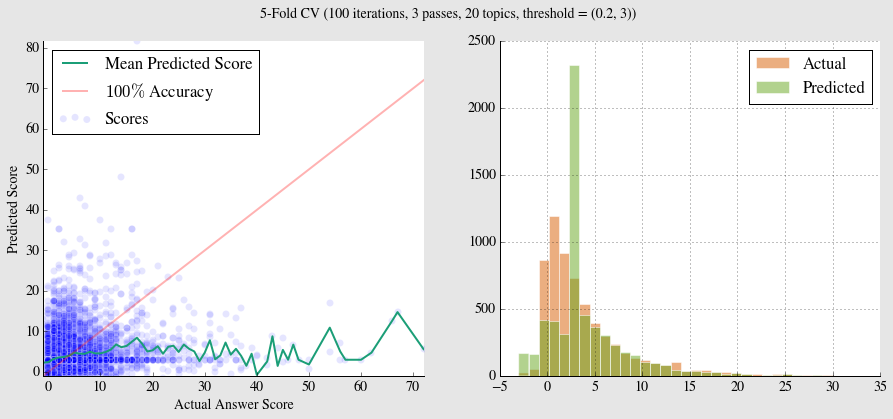

Regularized relative squared error (mean, std): (1.1581015341701464, 3.1883832050278325)
--------------------



In [41]:
plot_results(results1, '5-Fold CV (100 iterations, 3 passes, 20 topics, threshold = (0.2, 3))')

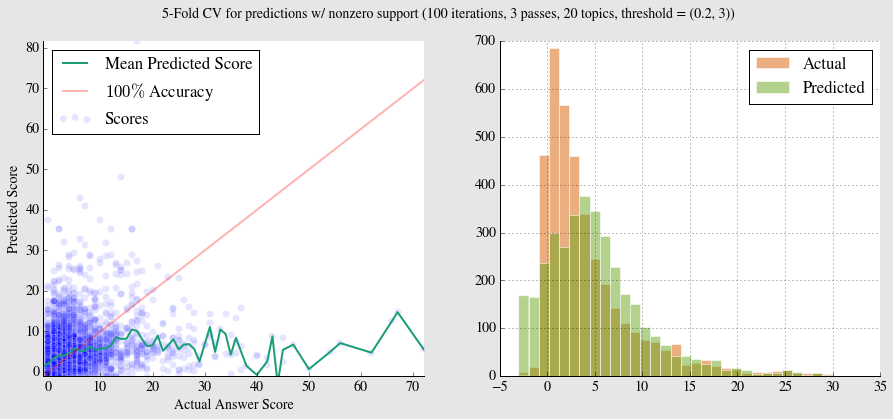

Regularized relative squared error (mean, std): (1.6235690024764449, 3.851514288196797)
--------------------



In [42]:
plot_results(results1[results1.support > 0], '5-Fold CV for predictions w/ nonzero support (100 iterations, 3 passes, 20 topics, threshold = (0.2, 3))')

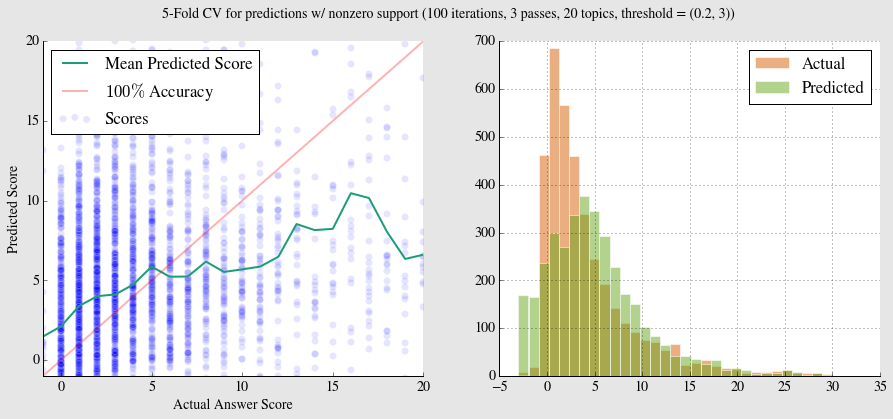

Regularized relative squared error (mean, std): (1.6235690024764449, 3.851514288196797)
--------------------



In [43]:
plot_results(results1[results1.support > 0], 
             '5-Fold CV for predictions w/ nonzero support (100 iterations, 3 passes, 20 topics, threshold = (0.2, 3))',
             xlim = 20, ylim = 20)

# Cross-Validation (function w/ params)

In [24]:
def cv_recommender(k = 7, w = [1,1,1], num_topics = 20, iterations = 50, passes = 5):
    """
    Uses the n_fold train/test splits to validate with the given parameters. Outputs 
    a dataframe with columns 'actual' and 'predicted'.
    
    WARNING: super hacky!
    """
    
    # make a list of dataframes
    validate_dfs = range(n_folds)
    for j in range(n_folds):
        validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
        validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
        validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])
        
    for i in range(n_folds):
        validate_dfs[i]['predicted_score'] = 0.
        validate_dfs[i]['support'] = 0.

    for i in range(n_folds):
        recommender = Recommender(site_name, train_df_dicts[i])
        recommender.train(num_topics = num_topics, iterations = iterations, passes = passes)
        for j in range(len(validate_dfs[i])):
            pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                     validate_dfs[i][['title','question','tags']].irow(j),
                                                     k = k, w = w)
            validate_dfs[i]['predicted_score'][j] = pred_score
            validate_dfs[i]['support'][j] = supp
            
    results = pd.DataFrame(columns=['actual','predicted','support'])
    results.actual = pd.concat([vdf.score for vdf in validate_dfs])
    results.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
    results.support = pd.concat([vdf.support for vdf in validate_dfs])
    
    return results

In [25]:
%%time
results2 = cv_recommender(num_topics=100, iterations=1000, passes=2)

CPU times: user 3min 51s, sys: 2.85 s, total: 3min 54s
Wall time: 1min 58s


LDA

    num_topics = 100
    iterations = 1000
    passes = 2
    k = 7
    w = [1,1,1] (title, question, tags)

Things to check/do:

1. keep some predictions with support 0? (need more features: comments, comment scores, reputation)
2. feed Tfidf vectors into LDA.

In [ ]:
plot_results(results2[results2.support >0], '5-Fold CV predictions w/ nonzero support (1000 iterations, 2 passes, 100 topics)')